#LIBRARIES IMPORT, FUNCTION DEFINITION AND DATA LOADING

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
"""
LIBRARIES IMPORT AND CONSTANTS DEFINITION
A seed is used to make training-validation split reproducible.
"""

import os

import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50V2, ResNet50
from sklearn import metrics

import matplotlib.pyplot as plt
import numpy as np


BASE_DIR = '/content/gdrive/My Drive/Quintavalla/'
DATA_FOLDER = BASE_DIR + "numpy data"
MODELS_FOLDER = BASE_DIR + "models"

MAX_UINT16 = 65535
VALIDATION_SPLIT = 0.2
MAX_NUMBER_OF_EPOCHS = 1000
DEFAULT_BATCH_SIZE = 64
SEED = 21

os.environ["PYTHONHASHSEED"]=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
"""
FUNCTION DEFINITION: DATA LOADING
The following functions load training and test data from the respective files. A 
dimension is added for compatibility with Keras models (the only grayscale channel
is replicated three times). Test baselines are not considered.
"""

def load_training_data():
  images = np.load(os.path.join(DATA_FOLDER, 'train_tensor.npy'))
  labels = np.load(os.path.join(DATA_FOLDER, 'train_labels.npy'))
  images = np.repeat(images[:, :, :, np.newaxis], 3, axis=3)
  return images, labels

def load_test_data():
  images = np.load(os.path.join(DATA_FOLDER, 'public_test_tensor.npy'))
  labels = np.load(os.path.join(DATA_FOLDER, 'public_test_labels.npy'))
  images = np.repeat(images[:, :, :, np.newaxis], 3, axis=3)
  not_baseline_indexes = np.where(labels != 0) 
  return images[not_baseline_indexes], labels[not_baseline_indexes]

In [ ]:
def plot_training_validation_accuracy(training_accuracy, validation_accuracy, tick):

  epochs = [ x+1 for x in range(len(training_accuracy)) ]

  plt.plot(epochs, training_accuracy, 'r', label="Training Accuracy")
  plt.plot(epochs, validation_accuracy, 'b', label="Validation Accuracy")
  plt.ylim(0, 1)
  plt.xticks(np.arange(min(epochs)-1, max(epochs)+1, tick))
  plt.title('Training and Validation Accuracy')
  plt.legend()

  plt.show()

def plot_training_validation_loss(training_loss, validation_loss, tick):

  epochs = [ x+1 for x in range(len(training_loss)) ]

  plt.plot(epochs, training_loss, 'r', label="Training Loss")
  plt.plot(epochs, validation_loss, 'b', label="Validation Loss")
  plt.xticks(np.arange(min(epochs)-1, max(epochs)+1, tick))
  plt.title('Training and Validation Loss')
  plt.legend()

  plt.show()

In [ ]:
"""
DATA LOADING
Data are loaded from files using functions defined above. 
"""

training_images, training_labels = load_training_data()
test_images, test_labels = load_test_data()

print(training_images.shape)
print(training_labels.shape)

print(test_images.shape)
print(test_labels.shape)

print(training_labels)
print(test_labels)

print(training_images.dtype)

TEST_SET_SIZE = test_images.shape[0]
IMAGE_HEIGHT = training_images.shape[1]
IMAGE_WIDTH =  training_images.shape[2]
CHANNELS = training_images.shape[3]

(5352, 150, 150, 3)
(5352,)
(336, 150, 150, 3)
(336,)
[0 2 0 ... 4 0 3]
[2 2 2 2 1 1 2 2 1 2 2 1 1 2 2 2 2 2 2 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 1 1 1 1 2 2 1 1 2 2 2 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 2 2 1
 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 2
 2 2 1 1 2 2 2 2 2 1 1 2 2 2 2 1 1 2 2 2 1 1 1 1 1 1 1 1 1 2 2 1 2 2 1 2 1
 1 1 1 2 2 1 1 1 1 1 2 2 2 1 1 2 2 1 2 2 1 1 1 1 2 2 1 1 1 1 1 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 4 3 3 3 3 4 4 3 3 3 3
 3 3 4 3 3 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 3 3 4 4 3 3 4 4 4 4 4 4
 4 3 3 3 3 4 4 4 3 3 3 3 3 3 4 3 3 3 3 3 3 4 4 4 4 3 3 3 3 4 3 3 4 4 4 3 3
 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 4 4 4 4 4 4 3 3 4 4 4 4 4 4 4 3 3 3 3 3 3 3
 3 3 3]
uint16


#SUBTASK 1: BENIGN-MALIGNANT CLASSIFICATION
This subsection is focused on Benign-Malignant classification problem. The idea
is to feed the model with baselines patches in order to have a greater number of training images. It is also possible that baselines patches contain features useful for the classification. Baselines are not considered in test and validations sets. Validation-training ratio is approximately 12%. Images are then normalized.

In [ ]:
"""
PREPROCESSING
"""

#compute validation set and training set size (validation split is 0.2, but then
#baseline images will be discarded)
m4_validation_size = int(VALIDATION_SPLIT*training_labels.size)
m4_training_size = training_labels.size-m4_validation_size

#training set-validation set split
m4_validation_images = training_images[-m4_validation_size:]
m4_validation_labels = training_labels[-m4_validation_size:]
m4_training_images = training_images[:m4_training_size]
m4_training_labels = training_labels[:m4_training_size]

#discard baselines from validation set
m4_not_baseline_validation_indexes = np.where(m4_validation_labels!=0)
m4_validation_images = m4_validation_images[m4_not_baseline_validation_indexes]
m4_validation_labels = m4_validation_labels[m4_not_baseline_validation_indexes]
m4_validation_size = m4_validation_labels.size

#0 is the label for benign cases, 1 is for malignant
for index in range(m4_training_labels.size):
  
  if index%2==1:

    if m4_training_labels[index]%2==1:

      m4_training_labels[index] = 0
      m4_training_labels[index-1] = 0

    else:
      m4_training_labels[index] = 1
      m4_training_labels[index-1] = 1

m4_test_labels = np.array([0 if n%2==1 else 1 for n in test_labels])
m4_validation_labels = np.array([0 if n%2==1 else 1 for n in m4_validation_labels])

#normalization
m4_training_images = m4_training_images / MAX_UINT16
m4_validation_images = m4_validation_images / MAX_UINT16
m4_test_images = test_images / MAX_UINT16

print("TRAINING SET")
print("Number of samples of class 0 (Benign): " + str(np.count_nonzero(m4_training_labels==0)) + 
      " (" + str(round((np.count_nonzero(m4_training_labels==0)/m4_training_size)*100,2)) + "%)")
print("Number of samples of class 1 (Malignant): " + str(np.count_nonzero(m4_training_labels==1)) + 
      " (" + str(round((np.count_nonzero(m4_training_labels==1)/m4_training_size)*100,2)) + "%)")
print("Training set size: " + str(m4_training_size))

print("VALIDATION SET")
print("Number of samples of class 0 (Benign): " + str(np.count_nonzero(m4_validation_labels==0)) + 
      " (" + str(round((np.count_nonzero(m4_validation_labels==0)/m4_validation_size)*100,2)) + "%)")
print("Number of samples of class 1 (Malignant): " + str(np.count_nonzero(m4_validation_labels==1)) + 
      " (" + str(round((np.count_nonzero(m4_validation_labels==1)/m4_validation_size)*100,2)) + "%)")
print("Validation set size: " + str(m4_validation_size))

print("TEST SET")
print("Number of samples of class 0 (Benign): " + str(np.count_nonzero(m4_test_labels==0)) + 
      " (" + str(round((np.count_nonzero(m4_test_labels==0)/TEST_SET_SIZE)*100,2)) + "%)")
print("Number of samples of class 1 (Malignant): " + str(np.count_nonzero(m4_test_labels==1)) + 
      " (" + str(round((np.count_nonzero(m4_test_labels==1)/TEST_SET_SIZE)*100,2)) + "%)")
print("Test set size: " + str(TEST_SET_SIZE))

print(m4_validation_labels)
print(m4_training_labels)

TRAINING SET
Number of samples of class 0 (Benign): 2468 (57.64%)
Number of samples of class 1 (Malignant): 1814 (42.36%)
Training set size: 4282
VALIDATION SET
Number of samples of class 0 (Benign): 334 (62.43%)
Number of samples of class 1 (Malignant): 201 (37.57%)
Validation set size: 535
TEST SET
Number of samples of class 0 (Benign): 219 (65.18%)
Number of samples of class 1 (Malignant): 117 (34.82%)
Test set size: 336
[0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0
 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 

##EXPERIMENT 1: FEEDING MODELS WITH BASELINES FOR BENIGN-MALIGNANT CLASSIFICATION - FROM-SCRATCH MODELS
In this experiment, from-scratch models are considered.  

###MODEL 4_A
This model is inspired by *AlexNet*. It is made up by three convolutional blocks, the last one made up by three convolutional layers and a max pooling layer. *Padding=same* ensure that convolutional layers does not affect the current shape. A Dropout layer is added to avoid overfitting. Two Fully Connected layers are added, and a final one is used for classification. Except for the latter which is *Sigmoid* based, the other layers are *ReLu* based. *Adam* is used as optimizer, 64 as *batch size*, 1e-6 as *learning rate*. A *Callback* with *patience=15* is used to prevent overfitting.

In [ ]:
"""
MODEL 4_A CREATION
"""

model4_a = models.Sequential(name="MODEL1_1_A")
model4_a.add(layers.Conv2D(filters=96, kernel_size=(9,9), strides=3, activation='relu', input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNELS), name="CONV_1"))
model4_a.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="MAX_POOL_1"))
model4_a.add(layers.Conv2D(filters=256, kernel_size=(5,5), padding="same", activation='relu', name="CONV_2"))
model4_a.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="MAX_POOL_2"))
model4_a.add(layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu', name="CONV_3"))
model4_a.add(layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu', name="CONV_4"))
model4_a.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation='relu', name="CONV_5"))
model4_a.add(layers.MaxPooling2D(pool_size=(3, 3), strides=2, name="MAX_POOL_3"))
model4_a.add(layers.Flatten(name="FLAT_1"))
model4_a.add(layers.Dropout(rate=0.25, name="DROP_1"))
model4_a.add(layers.Dense(units=1024, activation='relu', name="DENSE_1"))
model4_a.add(layers.Dense(units=1024, activation='relu', name="DENSE_2"))
model4_a.add(layers.Dense(units=1, activation='sigmoid', name="DENSE_3"))

model4_a.summary()

Model: "MODEL1_1_A"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 48, 48, 96)        23424     
_________________________________________________________________
MAX_POOL_1 (MaxPooling2D)    (None, 24, 24, 96)        0         
_________________________________________________________________
CONV_2 (Conv2D)              (None, 24, 24, 256)       614656    
_________________________________________________________________
MAX_POOL_2 (MaxPooling2D)    (None, 12, 12, 256)       0         
_________________________________________________________________
CONV_3 (Conv2D)              (None, 12, 12, 512)       1180160   
_________________________________________________________________
CONV_4 (Conv2D)              (None, 12, 12, 512)       2359808   
_________________________________________________________________
CONV_5 (Conv2D)              (None, 12, 12, 256)       1

In [ ]:
"""
CALLBACK DEFINITION
"""

callback = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [ ]:
"""
MODEL 4_A COMPILATION AND FITTING
"""

model4_a.compile(optimizer=optimizers.Adam(learning_rate=1e-6),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model4_a_history = model4_a.fit(x=m4_training_images,
          y=m4_training_labels, 
          epochs=MAX_NUMBER_OF_EPOCHS,
          batch_size=DEFAULT_BATCH_SIZE,
          validation_data=(m4_validation_images,m4_validation_labels),
          callbacks=[callback],
          shuffle=True)

Epoch 1/1000
67/67 [==============================] - 4s 55ms/step - loss: 0.6925 - accuracy: 0.5358 - val_loss: 0.6848 - val_accuracy: 0.6243
Epoch 2/1000
67/67 [==============================] - 3s 51ms/step - loss: 0.6893 - accuracy: 0.5747 - val_loss: 0.6792 - val_accuracy: 0.6243
Epoch 3/1000
67/67 [==============================] - 3s 51ms/step - loss: 0.6881 - accuracy: 0.5701 - val_loss: 0.6762 - val_accuracy: 0.6243
Epoch 4/1000
67/67 [==============================] - 3s 52ms/step - loss: 0.6867 - accuracy: 0.5775 - val_loss: 0.6746 - val_accuracy: 0.6243
Epoch 5/1000
67/67 [==============================] - 3s 52ms/step - loss: 0.6868 - accuracy: 0.5749 - val_loss: 0.6746 - val_accuracy: 0.6243
Epoch 6/1000
67/67 [==============================] - 3s 52ms/step - loss: 0.6844 - accuracy: 0.5853 - val_loss: 0.6741 - val_accuracy: 0.6243
Epoch 7/1000
67/67 [==============================] - 3s 51ms/step - loss: 0.6853 - accuracy: 0.5797 - val_loss: 0.6743 - val_accuracy: 0.6243

In [ ]:
"""
RESULTS ON TEST SET
"""

m4_a_test_loss, m4_a_test_accuracy = model4_a.evaluate(m4_test_images ,m4_test_labels)
print("TEST SET RESULTS")
print("ACCURACY " + str(m4_a_test_accuracy))
print("LOSS " + str(m4_a_test_loss))

11/11 [==============================] - 0s 17ms/step - loss: 0.6073 - accuracy: 0.6815
TEST SET RESULTS
ACCURACY 0.6815476417541504
LOSS 0.6072673797607422


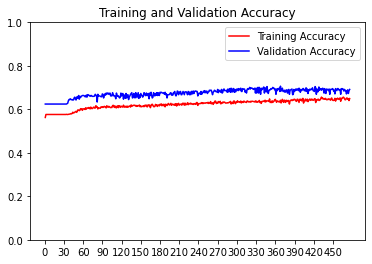

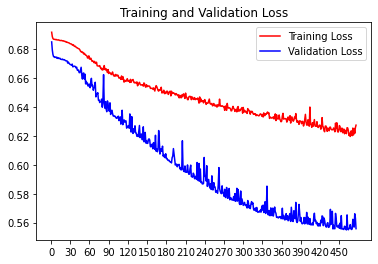

In [ ]:
"""
PLOTTING ACCURACY AND LOSS
"""

plot_training_validation_accuracy(model4_a_history.history['accuracy'], model4_a_history.history['val_accuracy'], 30.0)

plot_training_validation_loss(model4_a_history.history['loss'], model4_a_history.history['val_loss'], 30.0)

In [ ]:
"""
PRINT METRICS
Confusion matrix and other metrics are printed.
"""

m4_a_predicted_labels = [ int(x) for  x in np.around(model4_a.predict(m4_test_images),0) ]

print(metrics.classification_report(m4_test_labels, m4_a_predicted_labels))
print("CONFUSION MATRIX")
print(metrics.confusion_matrix(m4_test_labels, m4_a_predicted_labels))
print("AUC SCORE")
print(metrics.roc_auc_score(m4_test_labels, m4_a_predicted_labels))

              precision    recall  f1-score   support

           0       0.74      0.79      0.76       219
           1       0.55      0.47      0.51       117

    accuracy                           0.68       336
   macro avg       0.64      0.63      0.64       336
weighted avg       0.67      0.68      0.68       336

CONFUSION MATRIX
[[174  45]
 [ 62  55]]
AUC SCORE
0.6323030090153379


###MODEL 4_B
This model is obtained by simply stacking four convolutional blocks, each one made up by a single convolutional layer and a max pooling layer. A Dropout layer is added to avoid overfitting. A single Fully Connected layers is added, and a final one is used for classification. Except for the latter which is *Sigmoid* based, the other layers are *ReLu* based. *Adam* is used as optimizer, 64 as *batch size*, 1e-6 as *learning rate*. A *Callback* with *patience=15* is used to prevent overfitting.

In [ ]:
"""
MODEL 4_B CREATION
"""

model4_b = models.Sequential(name="MODEL4_B")
model4_b.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNELS), name="CONV_1"))
model4_b.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_1"))
model4_b.add(layers.Conv2D(filters=96, kernel_size=(2,2), activation='relu', name="CONV_2"))
model4_b.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_2"))
model4_b.add(layers.Conv2D(filters=192, kernel_size=(3,3), activation='relu', name="CONV_3"))
model4_b.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_3"))
model4_b.add(layers.Conv2D(filters=192, kernel_size=(3,3), activation='relu', name="CONV_4"))
model4_b.add(layers.MaxPooling2D(pool_size=(3,3), name="MAX_POOL_4"))
model4_b.add(layers.Flatten(name="FLAT_1"))
model4_b.add(layers.Dropout(rate=0.25, name="DROP_1"))
model4_b.add(layers.Dense(units=1024, activation='relu', name="DENSE_1"))
model4_b.add(layers.Dense(units=1, activation='sigmoid', name="DENSE_2"))

model4_b.summary()

Model: "MODEL4_B"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
MAX_POOL_1 (MaxPooling2D)    (None, 74, 74, 64)        0         
_________________________________________________________________
CONV_2 (Conv2D)              (None, 73, 73, 96)        24672     
_________________________________________________________________
MAX_POOL_2 (MaxPooling2D)    (None, 36, 36, 96)        0         
_________________________________________________________________
CONV_3 (Conv2D)              (None, 34, 34, 192)       166080    
_________________________________________________________________
MAX_POOL_3 (MaxPooling2D)    (None, 17, 17, 192)       0         
_________________________________________________________________
CONV_4 (Conv2D)              (None, 15, 15, 192)       331

In [ ]:
"""
CALLBACK DEFINITION
"""

callback = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [ ]:
"""
MODEL 4 B COMPILATION AND FITTING
"""

model4_b.compile(optimizer=optimizers.Adam(learning_rate=1e-6),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model4_b_history = model4_b.fit(x=m4_training_images,
          y=m4_training_labels, 
          epochs=MAX_NUMBER_OF_EPOCHS,
          batch_size=DEFAULT_BATCH_SIZE,
          validation_data=(m4_validation_images,m4_validation_labels),
          callbacks=[callback],
          shuffle=True)

Epoch 1/1000
67/67 [==============================] - 13s 83ms/step - loss: 0.6917 - accuracy: 0.5643 - val_loss: 0.6865 - val_accuracy: 0.6243
Epoch 2/1000
67/67 [==============================] - 5s 69ms/step - loss: 0.6902 - accuracy: 0.5747 - val_loss: 0.6828 - val_accuracy: 0.6243
Epoch 3/1000
67/67 [==============================] - 5s 69ms/step - loss: 0.6889 - accuracy: 0.5701 - val_loss: 0.6801 - val_accuracy: 0.6243
Epoch 4/1000
67/67 [==============================] - 5s 70ms/step - loss: 0.6872 - accuracy: 0.5775 - val_loss: 0.6780 - val_accuracy: 0.6243
Epoch 5/1000
67/67 [==============================] - 5s 70ms/step - loss: 0.6874 - accuracy: 0.5749 - val_loss: 0.6771 - val_accuracy: 0.6243
Epoch 6/1000
67/67 [==============================] - 5s 70ms/step - loss: 0.6849 - accuracy: 0.5853 - val_loss: 0.6762 - val_accuracy: 0.6243
Epoch 7/1000
67/67 [==============================] - 5s 70ms/step - loss: 0.6854 - accuracy: 0.5797 - val_loss: 0.6759 - val_accuracy: 0.624

In [ ]:
"""
RESULTS ON TEST SET
"""

m4_b_test_loss, m4_b_test_accuracy = model4_b.evaluate(m4_test_images ,m4_test_labels)
print("TEST SET RESULTS")
print("ACCURACY " + str(m4_b_test_accuracy))
print("LOSS " + str(m4_b_test_loss))

11/11 [==============================] - 0s 21ms/step - loss: 0.6147 - accuracy: 0.6726
TEST SET RESULTS
ACCURACY 0.6726190447807312
LOSS 0.6147342920303345


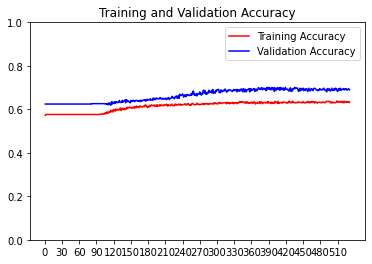

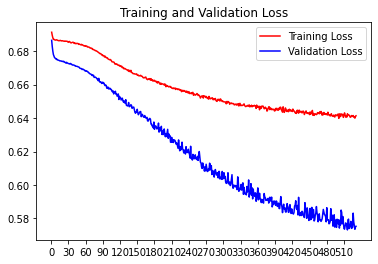

In [ ]:
"""
PLOTTING ACCURACY AND LOSS
"""

plot_training_validation_accuracy(model4_b_history.history['accuracy'], model4_b_history.history['val_accuracy'], 30.0)

plot_training_validation_loss(model4_b_history.history['loss'], model4_b_history.history['val_loss'], 30.0)

In [ ]:
"""
PRINT METRICS
Confusion matrix and other metrics are printed.
"""

m4_b_predicted_labels = [ int(x) for  x in np.around(model4_b.predict(m4_test_images),0) ]

print(metrics.classification_report(m4_test_labels, m4_b_predicted_labels))
print("CONFUSION MATRIX")
print(metrics.confusion_matrix(m4_test_labels, m4_b_predicted_labels))
print("AUC SCORE")
print(metrics.roc_auc_score(m4_test_labels, m4_b_predicted_labels))

              precision    recall  f1-score   support

           0       0.72      0.82      0.76       219
           1       0.54      0.40      0.46       117

    accuracy                           0.67       336
   macro avg       0.63      0.61      0.61       336
weighted avg       0.66      0.67      0.66       336

CONFUSION MATRIX
[[179  40]
 [ 70  47]]
AUC SCORE
0.6095304999414588


###CONCLUSIONS
Results obtained from the two models are very similar, and they do not present significant differencies with the results of previous experiments.

In [ ]:
"""
MODEL SAVING
Models are saved in model folder as 'benign_malignant_baseline_a' and 
'benign_malignant_baseline_b' .
"""

model4_a.save(os.path.join(MODELS_FOLDER,"benign_malignant_baseline_a.h5"))

In [ ]:
model4_b.save(os.path.join(MODELS_FOLDER,"benign_malignant_baseline_b.h5"))

##EXPERIMENT 2: FEEDING MODELS WITH BASELINES FOR BENIGN-MALIGNANT CLASSIFICATION - PRE-TRAINED MODELS
In this experiment, pre-trained models are used.

###VGG16-BASED
*VGG* is used as base in this experiment. The base is *frozen*, so the only trainable weights are the ones of the layers put on the top of the base. A Dropout layer is added to prevent overfitting. A single Fully Connected layer is added on the top of the base (*ReLu*), and a final one is used for the classification (*Sigmoid*). *Adam* is used as optimizer, 64 as *batch size*, 1e-6 as *learning rate*. A *Callback* with *patience=15* is used to prevent overfitting.

In [ ]:
"""
VGG16-BASED MODEL 
"""

vgg_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

#vgg base is frozen
vgg_base.trainable=False

model4_vgg = models.Sequential(name="MODEL_1_VGG")
model4_vgg.add(vgg_base)
model4_vgg.add(layers.Flatten(name="FLAT_1"))
model4_vgg.add(layers.Dropout(rate=0.25, name="DROP_1"))
model4_vgg.add(layers.Dense(1024, activation="relu", name="DENSE_1"))
model4_vgg.add(layers.Dense(1, activation="sigmoid", name="DENSE_2"))

model4_vgg.summary()

Model: "MODEL_1_VGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
FLAT_1 (Flatten)             (None, 8192)              0         
_________________________________________________________________
DROP_1 (Dropout)             (None, 8192)              0         
_________________________________________________________________
DENSE_1 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
DENSE_2 (Dense)              (None, 1)                 1025      
Total params: 23,105,345
Trainable params: 8,390,657
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
"""
CALLBACK DEFINITION
"""

callback = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [ ]:
"""
MODEL 4_VGG COMPILATION AND FITTING
"""

model4_vgg.compile(optimizer=optimizers.Adam(learning_rate=1e-6),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model4_vgg_history = model4_vgg.fit(x=m4_training_images,
          y=m4_training_labels, 
          epochs=MAX_NUMBER_OF_EPOCHS,
          batch_size=DEFAULT_BATCH_SIZE,
          validation_data=(m4_validation_images,m4_validation_labels),
          callbacks=[callback],
          shuffle=True)

Epoch 1/1000
67/67 [==============================] - 10s 144ms/step - loss: 0.6967 - accuracy: 0.5350 - val_loss: 0.6579 - val_accuracy: 0.6262
Epoch 2/1000
67/67 [==============================] - 9s 139ms/step - loss: 0.6899 - accuracy: 0.5653 - val_loss: 0.6534 - val_accuracy: 0.6262
Epoch 3/1000
67/67 [==============================] - 9s 140ms/step - loss: 0.6961 - accuracy: 0.5497 - val_loss: 0.6491 - val_accuracy: 0.6262
Epoch 4/1000
67/67 [==============================] - 9s 141ms/step - loss: 0.7001 - accuracy: 0.5393 - val_loss: 0.6446 - val_accuracy: 0.6262
Epoch 5/1000
67/67 [==============================] - 9s 140ms/step - loss: 0.6919 - accuracy: 0.5538 - val_loss: 0.6403 - val_accuracy: 0.6280
Epoch 6/1000
67/67 [==============================] - 9s 140ms/step - loss: 0.6822 - accuracy: 0.5784 - val_loss: 0.6379 - val_accuracy: 0.6318
Epoch 7/1000
67/67 [==============================] - 9s 138ms/step - loss: 0.6823 - accuracy: 0.5649 - val_loss: 0.6340 - val_accuracy

In [ ]:
"""
RESULTS ON TEST SET
"""

m4_vgg_test_loss, m4_vgg_test_accuracy = model4_vgg.evaluate(m4_test_images ,m4_test_labels)
print("TEST SET RESULTS")
print("ACCURACY " + str(m4_vgg_test_accuracy))
print("LOSS " + str(m4_vgg_test_loss))

11/11 [==============================] - 2s 111ms/step - loss: 0.6081 - accuracy: 0.6786
TEST SET RESULTS
ACCURACY 0.6785714030265808
LOSS 0.6080564260482788


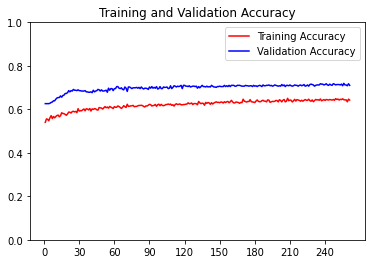

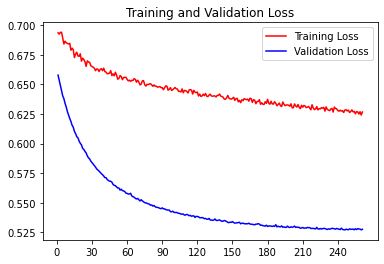

In [ ]:
"""
PLOTTING ACCURACY AND LOSS
"""

plot_training_validation_accuracy(model4_vgg_history.history['accuracy'], model4_vgg_history.history['val_accuracy'], 30.0)

plot_training_validation_loss(model4_vgg_history.history['loss'], model4_vgg_history.history['val_loss'], 30.0)

In [ ]:
"""
PRINT METRICS
Confusion matrix and other metrics are printed.
"""

m4_vgg_predicted_labels = [ int(x) for  x in np.around(model4_vgg.predict(m4_test_images),0) ]

print(metrics.classification_report(m4_test_labels, m4_vgg_predicted_labels))
print("CONFUSION MATRIX")
print(metrics.confusion_matrix(m4_test_labels, m4_vgg_predicted_labels))
print("AUC SCORE")
print(metrics.roc_auc_score(m4_test_labels, m4_vgg_predicted_labels))

              precision    recall  f1-score   support

           0       0.73      0.80      0.77       219
           1       0.55      0.44      0.49       117

    accuracy                           0.68       336
   macro avg       0.64      0.62      0.63       336
weighted avg       0.67      0.68      0.67       336

CONFUSION MATRIX
[[176  43]
 [ 65  52]]
AUC SCORE
0.624048706240487


###RESNET50-BASED
*ResNet50* is used as base for this experiment. The base is *frozen*, so the only trainable weights are the ones of the layers put on the top of the base. A Dropout layer is added to prevent overfitting. A Global Average Pooling is used instead of a Flatten one to reduce the total number of weights. A single Fully Connected layer is added on the top of the base (*ReLu*), and a final one is used for the classification (*Sigmoid*). *Adam* is used as optimizer, 64 as *batch size*, 1e-6 as *learning rate*. A *Callback* with *patience=15* is used to prevent overfitting.

In [ ]:
"""
RESNET50-BASED MODEL 
"""

res_base = ResNet50V2(weights='imagenet',
                    include_top=False,
                    input_shape=(150,150,3))

res_base.trainable=False

#res base is frozen 
model4_res = models.Sequential(name="MODEL_1_RES")
model4_res.add(res_base)
model4_res.add(layers.GlobalAveragePooling2D(name="GLOB_AVG_1"))
model4_res.add(layers.Dropout(rate=0.25, name="DROP_1"))
model4_res.add(layers.Dense(1024, activation="relu", name="DENSE_1"))
model4_res.add(layers.Dense(1, activation="sigmoid", name="DENSE_2"))

model4_res.summary()

Model: "MODEL_1_RES"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
GLOB_AVG_1 (GlobalAveragePoo (None, 2048)              0         
_________________________________________________________________
DROP_1 (Dropout)             (None, 2048)              0         
_________________________________________________________________
DENSE_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
DENSE_2 (Dense)              (None, 1)                 1025      
Total params: 25,664,001
Trainable params: 2,099,201
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
"""
CALLBACK DEFINITION
"""

callback = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [ ]:
"""
MODEL 4_RES COMPILATION AND FITTING
"""

model4_res.compile(optimizer=optimizers.Adam(learning_rate=1e-6),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model4_res_history = model4_res.fit(x=m4_training_images,
          y=m4_training_labels, 
          epochs=MAX_NUMBER_OF_EPOCHS,
          batch_size=DEFAULT_BATCH_SIZE,
          validation_data=(m4_validation_images,m4_validation_labels),
          callbacks=[callback],
          shuffle=True)

Epoch 1/1000
67/67 [==============================] - 18s 127ms/step - loss: 0.7621 - accuracy: 0.4542 - val_loss: 0.6852 - val_accuracy: 0.5682
Epoch 2/1000
67/67 [==============================] - 7s 99ms/step - loss: 0.7176 - accuracy: 0.4935 - val_loss: 0.6553 - val_accuracy: 0.6467
Epoch 3/1000
67/67 [==============================] - 7s 100ms/step - loss: 0.7044 - accuracy: 0.5144 - val_loss: 0.6374 - val_accuracy: 0.6299
Epoch 4/1000
67/67 [==============================] - 7s 99ms/step - loss: 0.6855 - accuracy: 0.5472 - val_loss: 0.6259 - val_accuracy: 0.6336
Epoch 5/1000
67/67 [==============================] - 7s 101ms/step - loss: 0.6781 - accuracy: 0.5578 - val_loss: 0.6174 - val_accuracy: 0.6411
Epoch 6/1000
67/67 [==============================] - 7s 101ms/step - loss: 0.6688 - accuracy: 0.5899 - val_loss: 0.6109 - val_accuracy: 0.6374
Epoch 7/1000
67/67 [==============================] - 7s 102ms/step - loss: 0.6810 - accuracy: 0.5740 - val_loss: 0.6052 - val_accuracy: 

In [ ]:
"""
RESULTS ON TEST SET
"""

m4_res_test_loss, m4_res_test_accuracy = model4_res.evaluate(m4_test_images ,m4_test_labels)
print("TEST SET RESULTS")
print("ACCURACY " + str(m4_res_test_accuracy))
print("LOSS " + str(m4_res_test_loss))

11/11 [==============================] - 1s 77ms/step - loss: 0.5791 - accuracy: 0.6726
TEST SET RESULTS
ACCURACY 0.6726190447807312
LOSS 0.5790512561798096


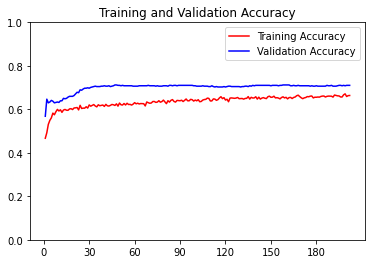

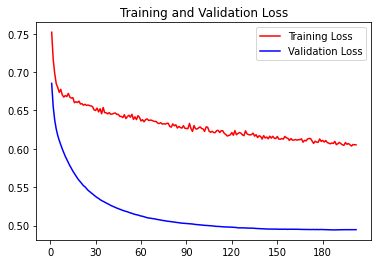

In [ ]:
"""
PLOTTING ACCURACY AND LOSS
"""

plot_training_validation_accuracy(model4_res_history.history['accuracy'], model4_res_history.history['val_accuracy'], 30.0)

plot_training_validation_loss(model4_res_history.history['loss'], model4_res_history.history['val_loss'], 30.0)

In [ ]:
"""
PRINT METRICS
Confusion matrix and other metrics are printed.
"""

m4_res_predicted_labels = [ int(x) for  x in np.around(model4_res.predict(m4_test_images),0) ]

print(metrics.classification_report(m4_test_labels, m4_res_predicted_labels))
print("CONFUSION MATRIX")
print(metrics.confusion_matrix(m4_test_labels, m4_res_predicted_labels))
print("AUC SCORE")
print(metrics.roc_auc_score(m4_test_labels, m4_res_predicted_labels))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76       219
           1       0.53      0.46      0.50       117

    accuracy                           0.67       336
   macro avg       0.63      0.62      0.63       336
weighted avg       0.66      0.67      0.67       336

CONFUSION MATRIX
[[172  47]
 [ 63  54]]
AUC SCORE
0.6234632946961713


###CONCLUSIONS
Again, the models provide similar results, similar to the ones of previous experiments too. 

In [ ]:
"""
MODEL SAVING
Models are saved in model folder as 'benign_malignant_baseline_vgg' and 
'benign_malignant_baseline_res' .
"""

model4_vgg.save(os.path.join(MODELS_FOLDER,"benign_malignant_baseline_vgg.h5"))

In [ ]:
model4_res.save(os.path.join(MODELS_FOLDER,"benign_malignant_baseline_res.h5"))

##CONCLUSIONS
The usage of baselines in training phase did not produce significant improvements of the test set metrics.